In [1]:
# Import python packages
import os
from glob import glob
import requests 
import json 

import numpy as np
import pandas as pd
import earthpy as et 
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.geometry import box
import contextily as ctx
from contextily import Place



In [2]:
# Set working directory (conditional loop)
if not os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'macrosystems')):
    print('Directory already exists.')
    print(os.getcwd())
else:
    os.makedir(os.path.join(et.io.HOME, 'earth-analytics'))
    print('No directory exists, creating one now.')
    print(os.getcwd())

Directory already exists.
C:\Users\Carson\earth-analytics\macrosystems


In [3]:
# Extra - Path to CONUS shapefile
country_boundary_us_path = os.path.join("earth-analytics", "data",
                                        "spatial-vector-lidar", 
                                        "usa", 
                                        "usa-boundary-dissolved.shp")

country_boundary_us_path

'earth-analytics\\data\\spatial-vector-lidar\\usa\\usa-boundary-dissolved.shp'

In [4]:
# Load .csv metadata pandas
# neon_metadata_path
neon_metadata_path = os.path.join('data/NEON_Field_Site_Metadata_20220224.csv')

neon_df = pd.read_csv(neon_metadata_path)
neon_df.head()

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_usgs_geology_unit,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,WAEOv1b;0,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,COTo;0|COQe;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,FLPOc;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,A003.BW002_114,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,NHJc1b;0,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0


In [5]:
neon_df.columns

Index(['field_domain_id', 'field_site_id', 'field_site_name',
       'field_site_type', 'field_site_subtype', 'field_colocated_site',
       'field_site_host', 'field_site_url', 'field_nonneon_research_allowed',
       'field_access_details', 'field_neon_field_operations_office',
       'field_latitude', 'field_longitude', 'field_geodetic_datum',
       'field_utm_northing', 'field_utm_easting', 'field_utm_zone',
       'field_site_county', 'field_site_state', 'field_site_country',
       'field_mean_elevation_m', 'field_minimum_elevation_m',
       'field_maximum_elevation_m', 'field_mean_annual_temperature_C',
       'field_mean_annual_precipitation_mm', 'field_dominant_wind_direction',
       'field_mean_canopy_height_m', 'field_dominant_nlcd_classes',
       'field_domint_plant_species', 'field_usgs_huc', 'field_watershed_name',
       'field_watershed_size_km2', 'field_lake_depth_mean_m',
       'field_lake_depth_max_m', 'field_tower_height_m',
       'field_usgs_geology_unit', 'f

In [6]:
# Convert to geopandas using lat&long to points
neon_gdf = gpd.GeoDataFrame(neon_df, geometry= gpd.points_from_xy(
    neon_df.field_longitude, neon_df.field_latitude, crs='EPSG:4326'))

neon_gdf

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-102.44715 39.75821)
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-82.00841 29.67598)
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-156.61936 71.28241)
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-71.28737 44.06389)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D07,WALK,Walker Branch NEON,Core Aquatic,Wadeable Stream,ORNL,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-84.27925 35.95738)
77,D13,WLOU,West St Louis Creek NEON,Gradient Aquatic,Wadeable Stream,NaN,US Forest Service,https://www.fs.usda.gov/wps/portal/fsinternet/...,Yes,Researchers should coordinate directly with th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-105.91540 39.89137)
78,D09,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,NaN,PRPO,US Fish and Wildlife Service,https://www.fws.gov/refuge/chase_lake/,Yes,This site host welcomes and encourages additio...,...,"Coarse, loamy, over-sandy or sandy, skeletal, ...",Typic Haplustolls,170.0,120,180,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.24133 47.12820)
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0,POINT (-121.95191 45.82049)


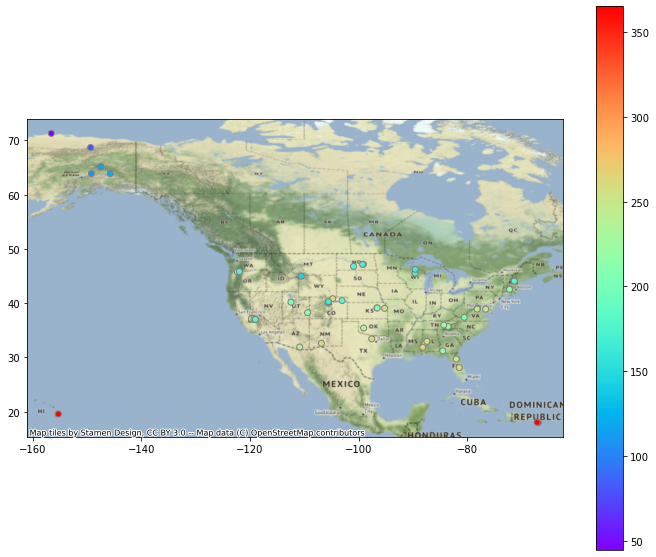

In [7]:
f, ax = plt.subplots(figsize=(12,10))

ax = neon_gdf.plot(column="field_avg_number_of_green_days",
                   legend=True, edgecolor="0.5", cmap="rainbow", ax=ax)

ctx.add_basemap(ax, crs=neon_gdf.crs.to_string())

plt.show()    

In [8]:
# Geopandas workflow: Using built in geopandas 
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_map


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


C:\Users\Carson\anaconda3\envs\earth-analytics-python\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Text(0.5, 1.0, 'NEON Sites - CONUS')

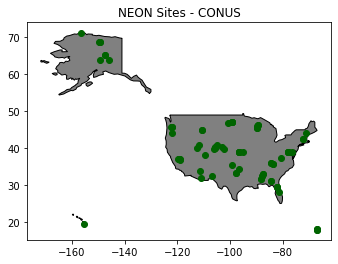

In [9]:
# Geopandas workflow: Grab CONUS Map for plotting neon sites
axis = world_map[world_map.name == 'United States of America'].plot(neon_gdf,
                                                                    color = 'grey',
                                                                    edgecolor = 'black')

neon_gdf.plot(ax=axis, color="darkgreen")

plt.title('NEON Sites - CONUS')

In [10]:
# Grouping for avg of green days

# Method 1
# Create filter list - terrestrial - core & gradient
neon_terrestrial_filter = ["Gradient Terrestrial", "Core Terrestrial"]
# Create terrestrial sites 
neon_terrestrial_sites = neon_gdf[neon_gdf.field_site_type.isin(neon_terrestrial_filter)]
neon_terrestrial_sites

# Create filter list - evergreen
neon_evergreen_filter = ["Grassland/Herbaceous", 
                        "Shrub/Scrub", 
                        "Cultivated Crops"]
# Create evergreen sites
neon_evergreen_sites = neon_terrestrial_sites[
    neon_terrestrial_sites.field_dominant_nlcd_classes.isin(
    neon_evergreen_filter)]
neon_evergreen_sites


# Method 2
# neon_terrestrial_sites = neon_df[(neon_df.field_site_type == "Core Terrestrial") & (neon_df.field_site_type == "Gradient Terrerstrial")] 
# neon_terrestrial_sites.reset_index(inplace=True)


,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
17,D09,DCFS,Dakota Coteau Field Site NEON,Gradient Terrestrial,NaN,PRLA,North Dakota Land Trust,https://www.land.nd.gov/,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Haplustolls,170.0,120,180,205,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.10656 47.16165)
29,D14,JORN,Jornada Experimental Range NEON,Gradient Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://jornada.nmsu.edu/,Yes,JORN encourages research activities that do no...,...,"Coarse, loamy, mixed, superactive, thermicc. T...",Typic Petrocalcids,260.0,80,185,245,340,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-106.84254 32.59069)
31,D06,KONA,Konza Prairie Agroecosystem NEON,Gradient Terrestrial,NaN,KING,Kansas State University,https://kpbs.konza.k-state.edu/scientist-infor...,Yes,KSU - Konza Prairie Biological Station (KSU) w...,...,"Fine, smectitic, mesic. Pachic Vertic Argiudo...",Pachic Vertic Argiudolls,210.0,90,160,210,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-96.61293 39.11045)
45,D09,NOGP,Northern Great Plains Research Laboratory NEON,Gradient Terrestrial,NaN,NaN,USDA Agricultural Research Service,https://www.ars.usda.gov/plains-area/mandan-nd...,Yes,This site host welcomes and encourages additio...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Argiustolls,175.0,115,170,200,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-100.91535 46.76972)
62,D14,SRER,Santa Rita Experimental Range NEON,Core Terrestrial,NaN,NaN,University of Arizona,https://taac.arizona.edu/sites/taac.arizona.ed...,Yes,SRER encourages research activities that do no...,...,NaN,Typic Torrifluvents,247.0,87|186,139|215,189|259,219|334,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-110.83549 31.91068)
64,D10,STER,North Sterling NEON,Gradient Terrestrial,NaN,NaN,Private,NaN,Very Limited,Very limited available via private land owner.,...,"Fine, silty, mixed, superactive, mesic. Pachic...",Pachic Argiustolls,180.0,90,150,190,270,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-103.02929 40.46189)


In [11]:
neon_evergreen_sites.head()

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
17,D09,DCFS,Dakota Coteau Field Site NEON,Gradient Terrestrial,NaN,PRLA,North Dakota Land Trust,https://www.land.nd.gov/,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Haplustolls,170.0,120,180,205,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.10656 47.16165)
29,D14,JORN,Jornada Experimental Range NEON,Gradient Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://jornada.nmsu.edu/,Yes,JORN encourages research activities that do no...,...,"Coarse, loamy, mixed, superactive, thermicc. T...",Typic Petrocalcids,260.0,80,185,245,340,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-106.84254 32.59069)
31,D06,KONA,Konza Prairie Agroecosystem NEON,Gradient Terrestrial,NaN,KING,Kansas State University,https://kpbs.konza.k-state.edu/scientist-infor...,Yes,KSU - Konza Prairie Biological Station (KSU) w...,...,"Fine, smectitic, mesic. Pachic Vertic Argiudo...",Pachic Vertic Argiudolls,210.0,90,160,210,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-96.61293 39.11045)
45,D09,NOGP,Northern Great Plains Research Laboratory NEON,Gradient Terrestrial,NaN,NaN,USDA Agricultural Research Service,https://www.ars.usda.gov/plains-area/mandan-nd...,Yes,This site host welcomes and encourages additio...,...,"Fine, loamy, mixed, superactive, frigid. Typic...",Typic Argiustolls,175.0,115,170,200,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-100.91535 46.76972)


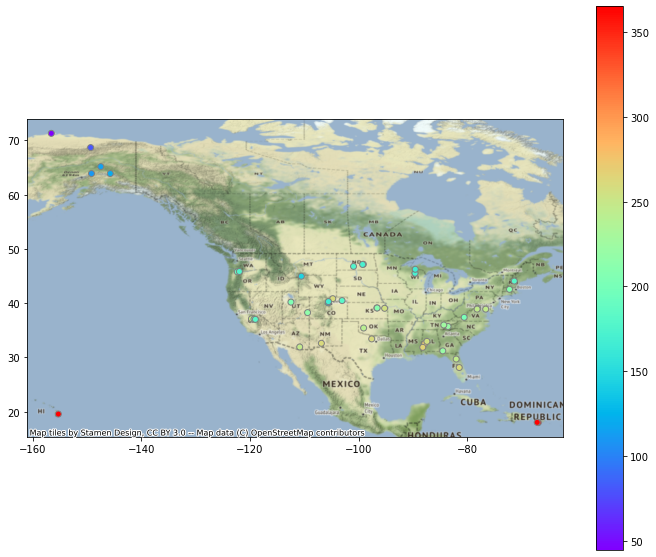

In [12]:
f, ax = plt.subplots(figsize=(12,10))

ax = neon_terrestrial_sites.plot(column="field_avg_number_of_green_days",
                   legend=True, edgecolor="0.5", cmap="rainbow", ax=ax)

ctx.add_basemap(ax, crs=neon_terrestrial_sites.crs.to_string())

plt.show()    

In [13]:
neon_terrestrial_sites.total_bounds[1]

17.96955

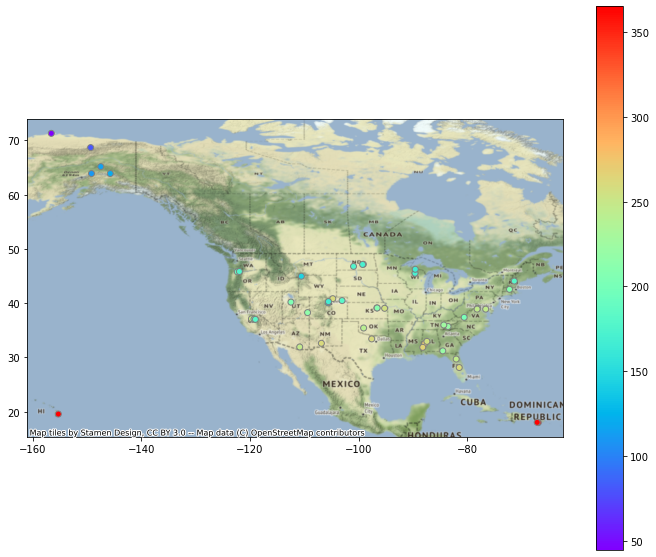

In [14]:
f, ax = plt.subplots(figsize=(12,10))

ax = neon_terrestrial_sites.plot(column="field_avg_number_of_green_days",
                   legend=True, edgecolor="0.5", cmap="rainbow", ax=ax)

# Create boundary point list


xlim = ([neon_terrestrial_sites.total_bounds[2],  
        neon_terrestrial_sites.total_bounds[1]])

ylim = ([neon_terrestrial_sites.total_bounds[2],  
        neon_terrestrial_sites.total_bounds[0]])

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ctx.add_basemap(ax, crs=neon_terrestrial_sites.crs.to_string())

plt.show() 

In [15]:
#Every request begins with the server's URL
SERVER = 'http://data.neonscience.org/api/v0/'
SITECODE = 'NIWO'

site_request = requests.get(SERVER + 'sites/' + SITECODE)

# Convert to Python JSON object
site_json = site_request.json()
site_json.keys()

dict_keys(['data'])

In [16]:
site_json['data'].keys()

dict_keys(['siteCode', 'siteName', 'siteDescription', 'siteType', 'siteLatitude', 'siteLongitude', 'stateCode', 'stateName', 'domainCode', 'domainName', 'deimsId', 'releases', 'dataProducts'])

In [17]:
for product in site_json['data']['dataProducts']:
    print(product['dataProductCode'],product['dataProductTitle'])
    

DP1.00001.001 2D wind speed and direction
DP1.00002.001 Single aspirated air temperature
DP1.00003.001 Triple aspirated air temperature
DP1.00004.001 Barometric pressure
DP1.00005.001 IR biological temperature
DP1.00006.001 Precipitation
DP1.00013.001 Wet deposition chemical analysis
DP1.00014.001 Shortwave radiation (direct and diffuse pyranometer)
DP1.00017.001 Dust and particulate size distribution
DP1.00022.001 Shortwave radiation (primary pyranometer)
DP1.00023.001 Shortwave and longwave radiation (net radiometer)
DP1.00024.001 Photosynthetically active radiation (PAR)
DP1.00033.001 Phenology images
DP1.00038.001 Stable isotopes in precipitation
DP1.00040.001 Soil heat flux plate
DP1.00041.001 Soil temperature
DP1.00042.001 Snow depth and understory phenology images
DP1.00043.001 Spectral sun photometer - calibrated sky radiances
DP1.00066.001 Photosynthetically active radiation (quantum line)
DP1.00094.001 Soil water content and water salinity
DP1.00095.001 Soil CO2 concentration

In [18]:
# List of data products useful to grab 

# DP1.10017.001 - Digital hemispheric photos of plot vegetation
# DP1.30003.001 - Discrete return LiDAR point cloud
# DP3.30015.001 - Ecosystem structure
# DP1.30012.001 - Field spectral data
# DP3.30014.001 - fPAR spectrometer 
# DP3.30012.001 - LAI spectrometer
# DP1.00033.001 - Phenology images
# DP3.30025.001 - Slope and Aspect - LiDAR
# DP3.30026.001 - Veg indices - mosaic

PRODUCTCODE = 'DP3.30026.001'

In [19]:
#Get available months and urls in PRODUCTCODE for selected Site site
#Loop through the 'dataProducts' list items (each one a dict) at the site

for product in site_json['data']['dataProducts']:
    if(product['dataProductCode'] == PRODUCTCODE):
        print('Available Months: ', product['availableMonths'])
        print('Urls for each Month: ', product['availableDataUrls'])

Available Months:  ['2017-09', '2018-08', '2019-08', '2020-08']
Urls for each Month:  ['https://data.neonscience.org/api/v0/data/DP3.30026.001/NIWO/2017-09', 'https://data.neonscience.org/api/v0/data/DP3.30026.001/NIWO/2018-08', 'https://data.neonscience.org/api/v0/data/DP3.30026.001/NIWO/2019-08', 'https://data.neonscience.org/api/v0/data/DP3.30026.001/NIWO/2020-08']


In [20]:
# Make Request to API for specific data
data_request = requests.get(SERVER + 'data/' + PRODUCTCODE +
                            '/' + SITECODE + '/' + '2020-08')

data_json = data_request.json()

# print(data_json)